In [1]:
import sys
# !{sys.executable} -m pip install tldextract
# !{sys.executable} -m pip freeze > requirements.txt

<div style='text-align:center;'>
<h1>S3D Tutorial @ GESIS</h1>
    <h2>Prediction Task on Boston House Pricing</h2>
</div>

In [2]:
__author__ = "Lisette Espin-Noboa"
__copyright__ = "Copyright 2018, S3D Tutorial, GESIS"
__credits__ = ["Peter G Fennell", "Zhiya Zuo", "Kristina Lerman"]
__reference__ = "https://arxiv.org/abs/1810.09841"
__license__ = "GPL"
__version__ = "1.0.3"
__maintainer__ = "Lisette Espin-Noboa"
__email__ = "Lisette.Espin@gesis.org"
__status__ = "Developing"

########################################################################
# Warnings
########################################################################
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

<h2>Dependences</h2>

In [3]:
%reload_ext autoreload
%autoreload 

########################################################################
# System
########################################################################
import os
import palettable
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.colors as mc
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.preprocessing import LabelBinarizer

########################################################################
# Local
########################################################################
from s3d import utils
from s3d.pys3d import PYS3D
from split_data import DataSplitter

<h2>Constants</h2>

In [4]:
TRAIN_DATA_FN = 'data/boston_train.csv'
TEST_DATA_FN = 'data/boston_test.csv'
COMPRESSION = None
INDEX_COL = 'ID'
TARGET_COL = 'medv'
TOPK = 5
NUMFOLDS = 3

<h2>Dataset</h2>
<p><div style='font-weight:bold;'>Source:</div><a href='https://www.kaggle.com/c/boston-housing/data'>Kaggle: Boston Housing</a></p>

<h3>Training dataset</h3>

In [5]:
train_df = pd.read_csv(TRAIN_DATA_FN, compression=COMPRESSION, index_col=INDEX_COL)
train_df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
ID,,,,,,,,,,,,,,
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


In [6]:
train_df.dtypes

crim       float64
zn         float64
indus      float64
chas         int64
nox        float64
rm         float64
age        float64
dis        float64
rad          int64
tax          int64
ptratio    float64
black      float64
lstat      float64
medv       float64
dtype: object

In [7]:
train_df.shape

(333, 14)

<h3>Testing dataset</h3>

In [8]:
test_df = pd.read_csv(TEST_DATA_FN, compression=COMPRESSION, index_col=INDEX_COL)
test_df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
ID,,,,,,,,,,,,,
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
6,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21
8,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,396.90,19.15
9,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,386.63,29.93
10,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311,15.2,386.71,17.10


In [9]:
test_df.dtypes

crim       float64
zn         float64
indus      float64
chas         int64
nox        float64
rm         float64
age        float64
dis        float64
rad          int64
tax          int64
ptratio    float64
black      float64
lstat      float64
dtype: object

In [10]:
test_df.shape

(173, 13)

<h2>Preprocessing data</h2>
<h3>1. Missing numerical values</h3>

In [11]:
### Replacing nan for median values
medians = {}
for i,r in train_df.select_dtypes(exclude=['object']).isna().any().reset_index().iterrows():
    if r[0]:
        c = r.iloc[0]
        medians[c] = train_df[c].median()

train_df.fillna(medians,inplace=True)
test_df.fillna(medians,inplace=True)

In [12]:
train_df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
ID,,,,,,,,,,,,,,
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


In [13]:
test_df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
ID,,,,,,,,,,,,,
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
6,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21
8,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,396.90,19.15
9,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,386.63,29.93
10,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311,15.2,386.71,17.10


<h3>2. Missing categorical values</h3>

In [14]:
### Replacing nan for 'undefined'
empty = {}
for i,r in train_df.select_dtypes(include=['object']).isna().any().reset_index().iterrows():
    if r[0]:
        c = r.iloc[0]
        empty[c] = 'undefined'

train_df.fillna(empty,inplace=True)
test_df.fillna(empty,inplace=True)

In [15]:
train_df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
ID,,,,,,,,,,,,,,
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


In [16]:
test_df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
ID,,,,,,,,,,,,,
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
6,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21
8,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,396.90,19.15
9,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,386.63,29.93
10,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311,15.2,386.71,17.10


<h3>3. Encoding categorical values</h3>

In [17]:
original_columns = train_df.select_dtypes(include=['object']).columns
for col in original_columns:
    lb = LabelBinarizer()
    lb_results = lb.fit_transform(train_df[col])
    columns = ['{}_code'.format(col)] if len(lb.classes_) == 2 else [ '{}_{}'.format(col,c) for c in lb.classes_]
    tmp = pd.DataFrame(lb_results, columns=columns, index=train_df.index)    
    
    train_df = pd.concat([train_df,tmp], axis=1)
    test_df = pd.concat([test_df,tmp], axis=1)

In [18]:
train_df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
ID,,,,,,,,,,,,,,
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


In [19]:
test_df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
ID,,,,,,,,,,,,,
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
6,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21
8,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,396.90,19.15
9,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,386.63,29.93
10,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311,15.2,386.71,17.10


<h3>3.1. Only numerical and encoded columns</h3>

In [20]:
train_df = train_df[list(set(train_df.columns)-set(original_columns))].copy()
test_df = train_df[list(set(test_df.columns)-set(original_columns))].copy()

In [21]:
train_df.head()

,chas,indus,zn,lstat,ptratio,rad,medv,crim,nox,rm,tax,dis,black,age
ID,,,,,,,,,,,,,,
1,0,2.31,18.0,4.98,15.3,1,24.0,0.00632,0.538,6.575,296,4.0900,396.90,65.2
2,0,7.07,0.0,9.14,17.8,2,21.6,0.02731,0.469,6.421,242,4.9671,396.90,78.9
4,0,2.18,0.0,2.94,18.7,3,33.4,0.03237,0.458,6.998,222,6.0622,394.63,45.8
5,0,2.18,0.0,5.33,18.7,3,36.2,0.06905,0.458,7.147,222,6.0622,396.90,54.2
7,0,7.87,12.5,12.43,15.2,5,22.9,0.08829,0.524,6.012,311,5.5605,395.60,66.6


In [22]:
test_df.head()

,chas,indus,zn,lstat,ptratio,rad,crim,nox,rm,tax,dis,black,age
ID,,,,,,,,,,,,,
1,0,2.31,18.0,4.98,15.3,1,0.00632,0.538,6.575,296,4.0900,396.90,65.2
2,0,7.07,0.0,9.14,17.8,2,0.02731,0.469,6.421,242,4.9671,396.90,78.9
4,0,2.18,0.0,2.94,18.7,3,0.03237,0.458,6.998,222,6.0622,394.63,45.8
5,0,2.18,0.0,5.33,18.7,3,0.06905,0.458,7.147,222,6.0622,396.90,54.2
7,0,7.87,12.5,12.43,15.2,5,0.08829,0.524,6.012,311,5.5605,395.60,66.6


<h3>4. Renaming target columns</h3>

In [23]:
try:
    target_column = TARGET_COL
    train_df.rename(columns={target_column:'target'}, inplace=True)
    
    columns = ['target']
    columns.extend(list(set(train_df.columns) - set(['target'])))
    columns = list(columns)    
    train_df = train_df[columns].copy()
    print('renaming column {} to target, done!'.format(target_column))
    
    data_train_path = TRAIN_DATA_FN.replace('train','train_ready')    
    train_df.to_csv(data_train_path, compression=COMPRESSION, index=False)
    print('new file: {}'.format(data_train_path))
    
    data_test_path = TEST_DATA_FN.replace('test','test_ready')    
    test_df.to_csv(data_test_path, compression=COMPRESSION, index=False)
    print('new file: {}'.format(data_test_path))    
except Exception as ex:
    print(ex)

renaming column medv to target, done!
new file: data/boston_train_ready.csv
new file: data/boston_test_ready.csv


In [24]:
train_df.head()

,target,chas,indus,zn,nox,lstat,rad,crim,ptratio,rm,tax,dis,black,age
ID,,,,,,,,,,,,,,
1,24.0,0,2.31,18.0,0.538,4.98,1,0.00632,15.3,6.575,296,4.0900,396.90,65.2
2,21.6,0,7.07,0.0,0.469,9.14,2,0.02731,17.8,6.421,242,4.9671,396.90,78.9
4,33.4,0,2.18,0.0,0.458,2.94,3,0.03237,18.7,6.998,222,6.0622,394.63,45.8
5,36.2,0,2.18,0.0,0.458,5.33,3,0.06905,18.7,7.147,222,6.0622,396.90,54.2
7,22.9,0,7.87,12.5,0.524,12.43,5,0.08829,15.2,6.012,311,5.5605,395.60,66.6


In [25]:
test_df.head()

,chas,indus,zn,lstat,ptratio,rad,crim,nox,rm,tax,dis,black,age
ID,,,,,,,,,,,,,
1,0,2.31,18.0,4.98,15.3,1,0.00632,0.538,6.575,296,4.0900,396.90,65.2
2,0,7.07,0.0,9.14,17.8,2,0.02731,0.469,6.421,242,4.9671,396.90,78.9
4,0,2.18,0.0,2.94,18.7,3,0.03237,0.458,6.998,222,6.0622,394.63,45.8
5,0,2.18,0.0,5.33,18.7,3,0.06905,0.458,7.147,222,6.0622,396.90,54.2
7,0,7.87,12.5,12.43,15.2,5,0.08829,0.524,6.012,311,5.5605,395.60,66.6


<h2>S3D</h2>
<h3>1. Splitting training data</h3>

In [26]:
data_name = 'housepricesBOSTON'
classification_flag = False
standardize_flag = True

ds = DataSplitter(data_train_path, 
                  data_name,
                  classification_flag,
                  standardize_flag)

num_folds = NUMFOLDS
num_jobs = num_folds
ds.split_data(num_folds, num_jobs)

standardize values
splitting housepricesBOSTON data (333 rows) into 3 folds
using 3 cores
working on fold 0 fold 0 (elapsed time: 0.08 seconds)
working on fold 2 fold 2 (elapsed time: 0.07 seconds)
working on fold 1 fold 1 (elapsed time: 0.06 seconds)


<h3>2. Initialize model</h3>

In [27]:
s3d = PYS3D(data_name, classification_flag=classification_flag)

...s3d initializing...
s3d with housepricesBOSTON data, splitted into 3 folds
data will be loaded from splitted_data/housepricesBOSTON/
built models will be saved to models/housepricesBOSTON/
predictions will be saved to predictions/housepricesBOSTON/
temporary subfolders in  tmp/housepricesBOSTON
...done initializing...



<h3>3. Hyperparameter tunning</h3>

<h4>3.1 Cross validation</h4>

In [28]:
lambda_list = [0.01, 0.03, 0.05, 0.001, 0.003, 0.0001, 0.0003, 0.00001, 0.00003]
num_features = TOPK
num_jobs = len(lambda_list)

s3d.cross_val_multicore(lambda_list, 
                        num_features, 
                        num_cores=num_jobs,
                        calc_threshold=False)


--- cross validation (9 cores) on housepricesBOSTON data ---


/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:137: UserWarning: 5 features requested by only 3 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:222: UserWarning: 5 features requested by only 3 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:137: UserWarning: 5 features requested by only 4 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:222: UserWarning: 5 features requested by only 4 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:137: UserWarning: 5 features requested by only 4 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:222: UserWarning: 5 features requested by only 4 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:137: UserWarning: 5 features requested by only 4 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:222: UserWarning: 5 features requested by only 4 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:13

/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:222: UserWarning: 5 features requested by only 2 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:137: UserWarning: 5 features requested by only 2 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:222: UserWarning: 5 features requested by only 2 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:137: UserWarning: 5 features requested by only 2 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:222: UserWarning: 5 features requested by only 2 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:137: UserWarning: 5 features requested by only 2 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:222: UserWarning: 5 features requested by only 2 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:137: UserWarning: 5 features requested by only 2 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:13

--- done multi-core cv; total elapsed time 8.47 seconds


<h4>3.1 Evaluation best hyperparameters</h4>

In [29]:
metric = 'mae'
metric_name = 'Mean Absolute Error'
eval_df = s3d.evaluate(num_jobs=num_jobs, cv_metric=metric)
dimensions = eval_df.num_features.values
eval_df

evaluating s3d model using 9 cores...
command: ./s3d/train -infile:splitted_data/housepricesBOSTON/0/train.csv -outfolder:models/housepricesBOSTON/0/ -lambda:0.01 -ycol:0 -start_skip_rows:-1 -end_skip_rows:-1 -max_features:1
command: ./s3d/train -infile:splitted_data/housepricesBOSTON/2/train.csv -outfolder:models/housepricesBOSTON/2/ -lambda:0.05 -ycol:0 -start_skip_rows:-1 -end_skip_rows:-1 -max_features:2
command: ./s3d/train -infile:splitted_data/housepricesBOSTON/1/train.csv -outfolder:models/housepricesBOSTON/1/ -lambda:0.05 -ycol:0 -start_skip_rows:-1 -end_skip_rows:-1 -max_features:3


,num_features,mae,mae_median,mse,r2,lambda_,split_version
0,1,-0.755006,-0.457453,-1.175565,-0.061201,0.01,0.0
1,3,-0.387538,-0.227857,-0.408324,0.406247,0.05,1.0
2,2,-0.481426,-0.269168,-0.602783,0.513641,0.05,2.0


In [30]:
utils.find_best_param('cv/{}/performance.csv'.format(data_name), metric)

,split_version,lambda_,num_features,best_value,metric
0,0,0.01,1,-0.503622,mae
1,1,0.05,3,-0.491347,mae
2,2,0.05,2,-0.489812,mae


In [31]:
df_tmp = pd.read_csv('cv/{}/performance.csv'.format(data_name))
validation_metric = 'mae'
id_vars_list = ['split_version', 'lambda_', 'num_features']
cv_df = df_tmp.groupby(id_vars_list).mean()[[validation_metric, 'r2','train_r2']]
idx = cv_df.groupby('split_version')[validation_metric].transform(max) == cv_df[validation_metric] 
cv_df[idx]

,,,mae,r2,train_r2
split_version,lambda_,num_features,,,
0,0.01,1,-0.503622,0.427768,0.889373
1,0.05,3,-0.491347,0.367926,0.920687
2,0.05,2,-0.489812,0.502197,0.878757


<h3>5. Visualization</h3>

<h4>5.1. Lambda selection</h4>

/ssd/lespin/virtualenv/python3.5/lib/python3.5/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/ssd/lespin/virtualenv/python3.5/lib/python3.5/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/ssd/lespin/virtualenv/python3.5/lib/python3.5/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/ssd/lespin/virtualenv/python3.5/lib/python3.5/site-packages/seaborn/categorical

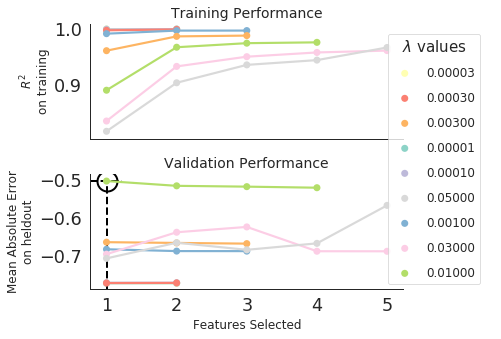

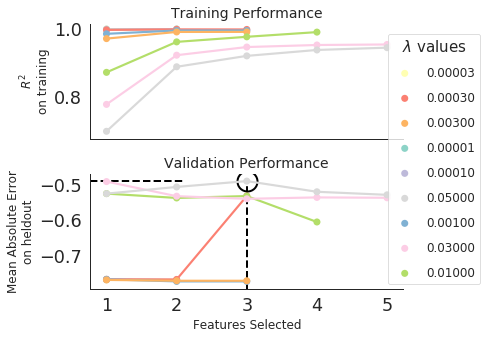

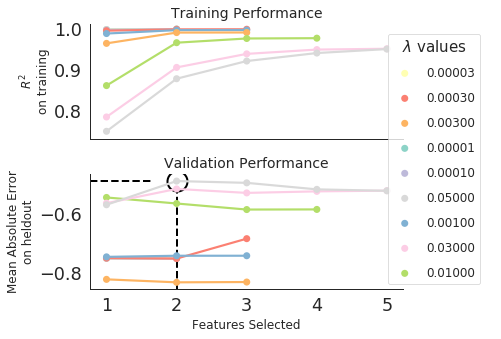

In [32]:
legend_kwargs = {'ncol': 1, 'loc': 7, 'labelspacing': 1,
                 'title': r'$\lambda$ values',
                 'prop': {'size': 12},
                 'bbox_to_anchor': (1, .5),
                }
with sns.axes_style('white'):    
    for num_fold in range(num_folds):
        fp, best_n_f, best_val, best_lambda_, split_version = utils.visualize_cv('cv/{}/performance.csv'.format(data_name), 
                                                                         validation_metric=metric,
                                                                         metric_name=metric_name,
                                                                         legend_kwargs=legend_kwargs,
                                                                         split_version=num_fold, 
                                                                         color_list=palettable.colorbrewer.qualitative.Set3_12.mpl_colors)

<h4>5.2. Feature importance</h4>

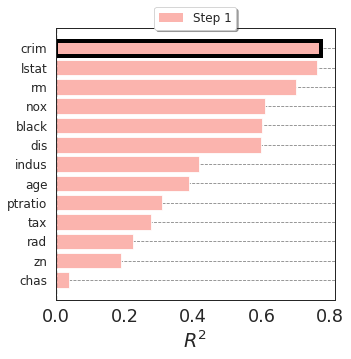

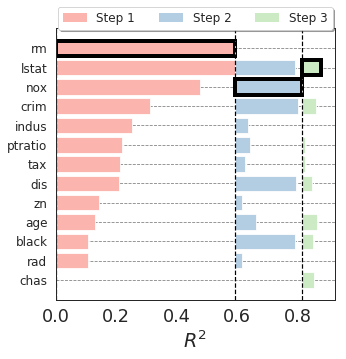

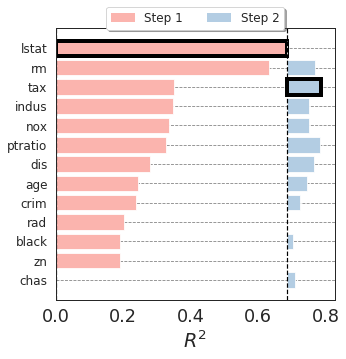

In [33]:
with sns.axes_style('white'):
    for num_fold in range(num_folds):
        train_model = 'models/{}/{}/'.format(data_name,num_fold)
        fig, ax = utils.visualize_s3d_steps(train_model, figsize=(5,5))    
        _ = ax.set_yticklabels(ax.get_yticklabels(),fontdict={'size':12}) 

<h4>5.3. Redundancy between features</h4>

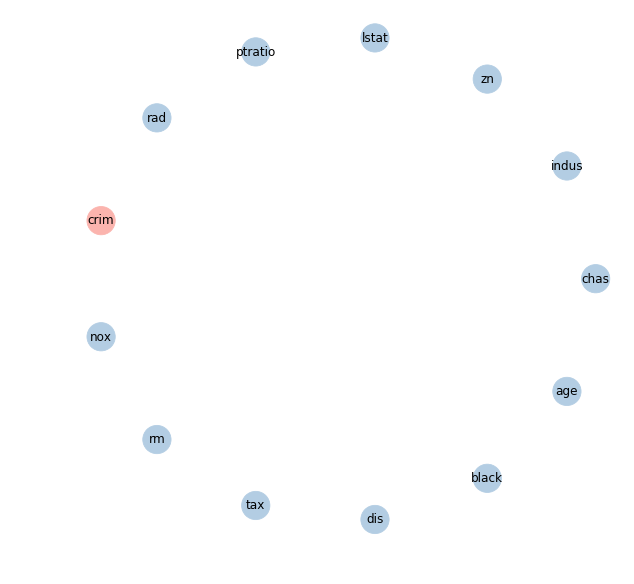

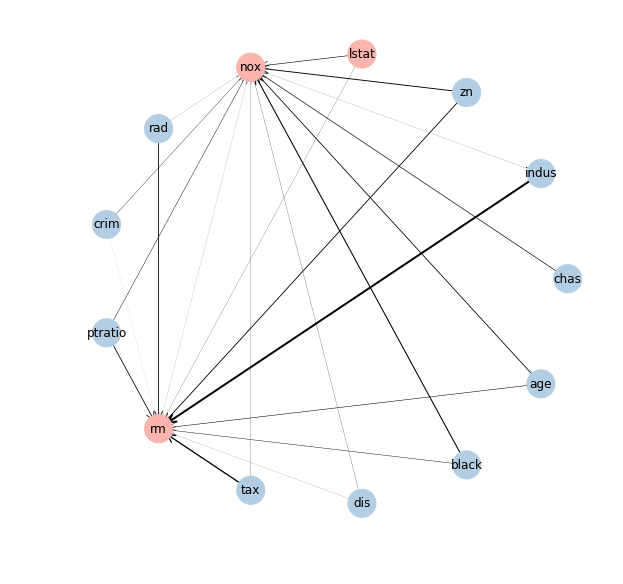

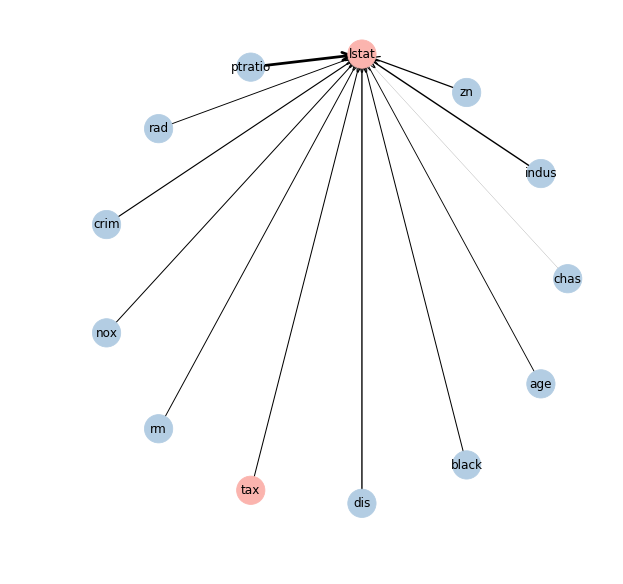

In [34]:
with sns.axes_style('white'):
    for num_fold in range(num_folds):
        train_model = 'models/{}/{}/'.format(data_name,num_fold)
        net, (fig, ax) = utils.visualize_feature_network(model_folder=train_model, w_scale=5)

<h4>5.4. Feature binning</h4>

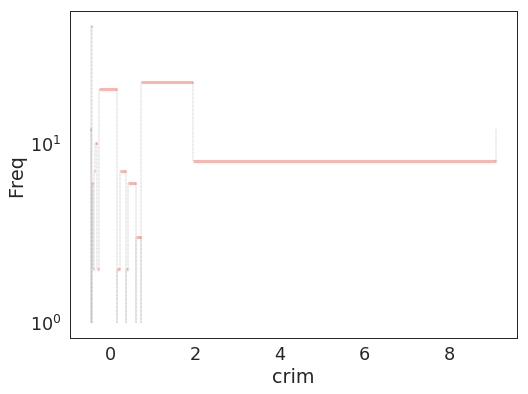

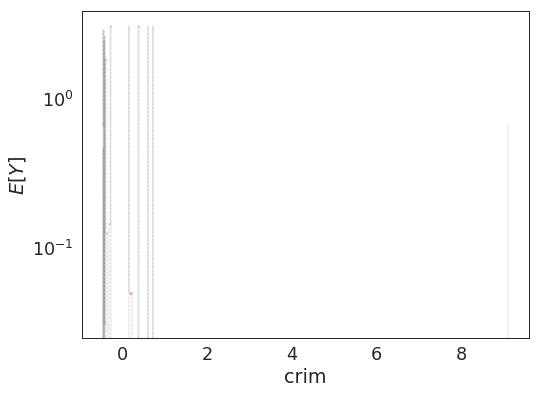

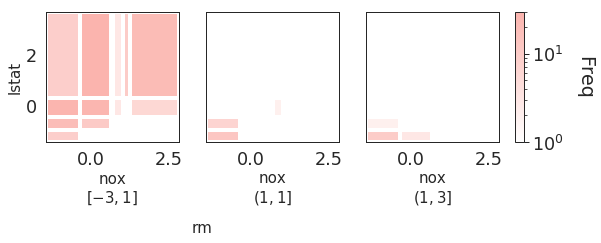

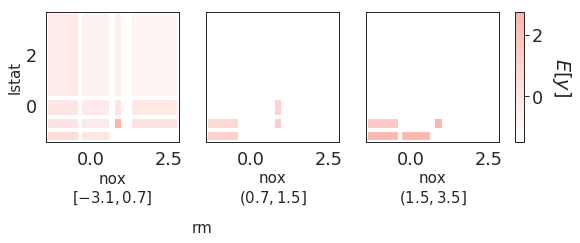

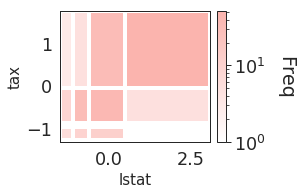

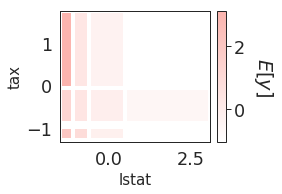

In [35]:
thres = 0
pink_color = '#FBB4AE'
my_cmap = mc.LinearSegmentedColormap.from_list('custom_pink', ['#ffffff', pink_color], N=256)

with sns.axes_style('white'):
    for num_fold in range(num_folds):
        train_model = 'models/{}/{}/'.format(data_name,num_fold)
        dim = int(dimensions[num_fold])

        splits_at_dim, N_dim, intensity_dim, pred_dim, chosen_f_dim = utils.visualize_s3d_model_reader(train_model, dim, thres)
        
        if dim == 1:
            # frequency
            fig, ax = utils.visualize_s3d_model_1d(splits_at_dim, N_dim,
                                            xlab=chosen_f_dim[0], ylab='Freq',
                                            xscale='linear',
                                            hlines_kwargs={'color': pink_color, 'linewidth': 3})
            
            # expected value
            fig, ax = utils.visualize_s3d_model_1d(splits_at_dim, intensity_dim, 
                                       xlab=chosen_f_dim[0], ylab=r'$E[Y]$',
                                       xscale='linear',
                                       hlines_kwargs={'color': pink_color, 'linewidth': 3})
        else:        
            # frequency
            fig, ax_arr, _ = utils.visualize_s3d_model(dim, splits_at_dim, my_cmap,
                                            N_dim, 'Freq', chosen_f_dim, 
                                            xscale='linear', yscale='linear',
                                            norm_func=mc.LogNorm,
                                            xbins_lab_decimal=0)

            # expected value
            fig, ax_arr, _ = utils.visualize_s3d_model(dim, splits_at_dim, my_cmap, 
                                            intensity_dim, '$E[y]$', chosen_f_dim, 
                                            xscale='linear', yscale='linear',
                                            xbins_lab_decimal=1)

<h4>5.5. X vs. Y</h4>

medv vs crim: -0.41
medv vs lstat: -0.74
medv vs ptratio: -0.48
medv vs rm: 0.69
medv vs indus: -0.47
medv vs tax: -0.45
medv vs nox: -0.41


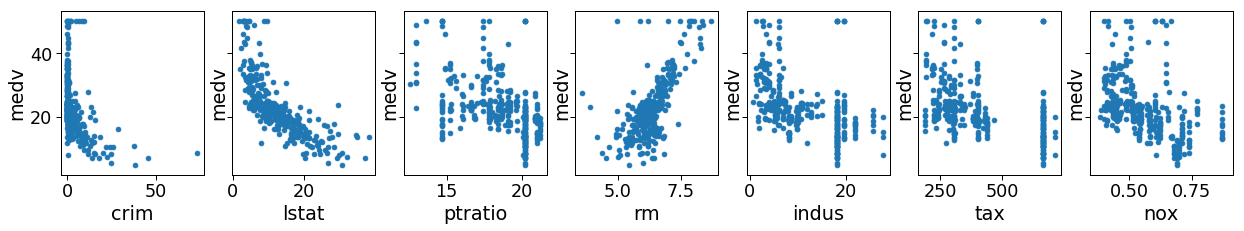

In [36]:
features = ['crim','lstat','ptratio','rm','indus','tax','nox']
w = len(features)*3
fig,axes = plt.subplots(1,len(features),figsize=(w,3), sharey=True)
for c,feature in enumerate(features):
    x = train_df[feature].values
    y = train_df.target.values
    cor = np.corrcoef(x, y)
    axes[c].scatter(x, y)
    print('{} vs {}: {}'.format(TARGET_COL, feature, round(cor[0,1],2)))
    _ = axes[c].set_xlabel(feature)
    _ = axes[c].set_ylabel(TARGET_COL)

<h4>5.6. Predictions on validation data</h4>

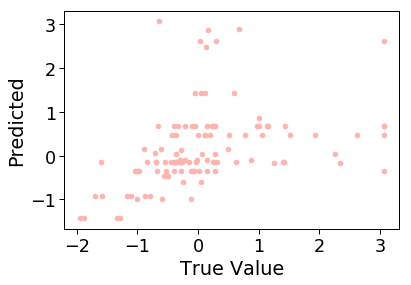

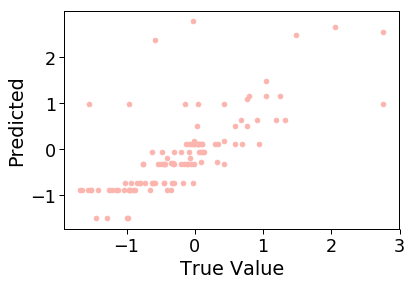

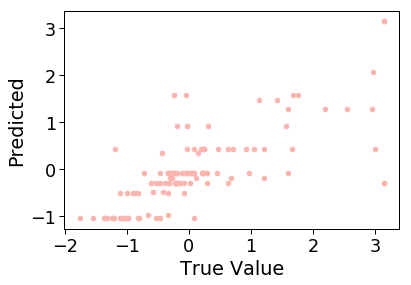

In [37]:
# performance prediction
for num_fold in range(num_folds):
    features = s3d.get_features(num_fold)
    num_features = len(features)

    y_score = pd.np.loadtxt(os.path.join(s3d.prediction_path, str(num_fold), 'predicted_expectations_MF_{}.csv'.format(int(num_features))))
    y_true = pd.read_csv( os.path.join(s3d.data_path, str(num_fold), 'test.csv')  )['target'].values

    if s3d.classification_flag:
        thres = s3d.calculate_disc_threshold(os.path.join(s3d.model_path,str(num_fold)), num_features)
        y_pred = (y_score >= thres).astype(int)

        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y_true, y_pred)
        np.set_printoptions(precision=2)

        # Plot non-normalized confusion matrix
        plt.figure()
        utils.plot_confusion_matrix(cnf_matrix, classes=classes, title='Confusion matrix, without normalization')
        plt.show()

        # Plot normalized confusion matrix
        plt.figure()
        utils.plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')
        plt.show()

    else:
        y_pred = y_score
        plt.scatter(y_true, y_pred, color=pink_color)
        plt.xlabel('True Value')
        plt.ylabel('Predicted')
        plt.show()


<div style='text-align:center;'>
<h1>Scikit Learn</h1>
</div>

<h2>Logistic Regression: Lasso</h2>

In [38]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

df_lasso = pd.DataFrame(columns={'nfold','alpha','coef','intercept','train_score','test_score','r2'})
feature_names = None

for alpha in [0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5]:
    for nfold in np.arange(NUMFOLDS):
        
        # using the same splitted_data as S3D
        path = 'splitted_data/<name>/<nfold>/<type>.csv'
        
        X_train = pd.read_csv(path.replace('<nfold>',str(nfold)).replace('<name>',data_name).replace('<type>','train'))
        X_test = pd.read_csv(path.replace('<nfold>',str(nfold)).replace('<name>',data_name).replace('<type>','test'))
        
        if feature_names is None:
            feature_names = X_train.columns.drop('target')
            
        y_train = X_train.target.values
        y_test = X_test.target.values
        
        X_train = X_train.drop('target',axis=1).values
        X_test = X_test.drop('target',axis=1).values
        
        clf = Lasso(alpha=alpha)
        reg = clf.fit(X_train, y_train)

        coef = clf.coef_
        intercept = clf.intercept_

        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)

        y_pred_lasso = reg.predict(X_test)
        r2_score_lasso = r2_score(y_test, y_pred_lasso)

        df_lasso = df_lasso.append({'nfold':nfold,
                                    'alpha':alpha,
                                    'coef':coef,
                                    'intercept':intercept,
                                    'train_score':train_score,
                                    'test_score':test_score,
                                    'r2':r2_score_lasso }, ignore_index=True)

df_lasso = df_lasso.sort_values('nfold')        

# all outcomes        
df_lasso_coef = df_lasso.coef.apply(pd.Series).rename(columns={i:c for i,c in enumerate(feature_names)})

# best hyperparameter (alpha)
idx = df_lasso.groupby(['nfold'])['r2'].transform(max) == df_lasso['r2'] 

In [39]:
df_lasso[idx].sort_values('nfold')

,nfold,test_score,intercept,alpha,train_score,r2,coef
9,0,0.719022,5.138723e-15,0.010,0.718110,0.719022,"[0.11389805596587614, -0.0, 0.0930467562308042..."
7,1,0.664975,4.693074e-15,0.005,0.738538,0.664975,"[0.08906823837681259, -0.0, 0.0717082556779145..."
11,2,0.641848,2.769758e-15,0.010,0.764819,0.641848,"[0.08050702063141031, 0.0, 0.10783186060681395..."


In [40]:
df_lasso_coef[idx]

,chas,indus,zn,nox,lstat,rad,crim,ptratio,rm,tax,dis,black,age
9,0.113898,-0.0,0.093047,-0.166387,-0.583035,0.201808,0.000000,-0.194397,0.193239,-0.097086,-0.240334,0.117695,0.088222
7,0.089068,-0.0,0.071708,-0.165720,-0.378352,0.227880,-0.045309,-0.177737,0.382098,-0.140919,-0.303495,0.063034,-0.041499
11,0.080507,0.0,0.107832,-0.117360,-0.395169,0.151917,-0.073616,-0.176516,0.324175,-0.136632,-0.314574,0.115846,-0.090338


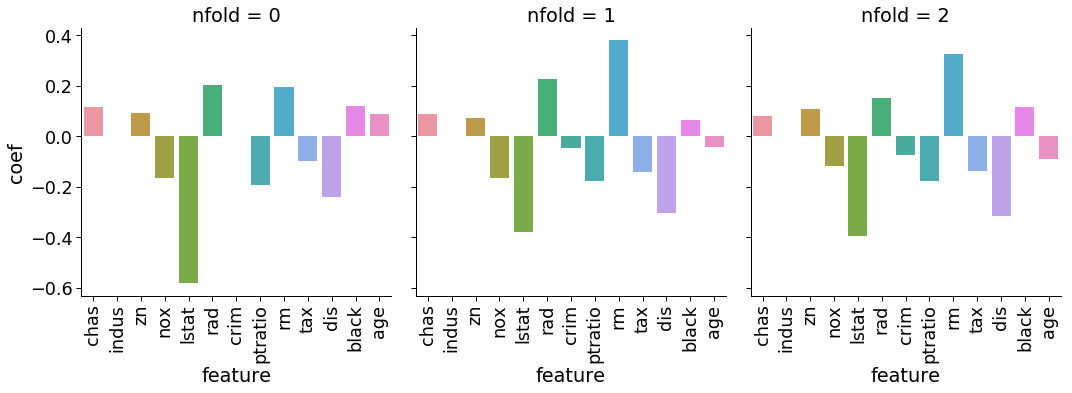

In [41]:
tmp = df_lasso_coef[idx].reset_index(drop=True).unstack().reset_index(name='coef').rename(columns={'level_0': 'feature', 'level_1': 'nfold'})
fg = sns.catplot(data=tmp, kind='bar', x='feature', y='coef', col='nfold')
for ax in fg.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

<h2>Logistic Regression: Elastic Net</h2>

In [42]:
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet

df_elastic = pd.DataFrame(columns={'nfold','l1','alpha','coef','intercept','train_score','test_score','r2'})
feature_names = None

for alpha in [0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5]:
    for l1 in [0.5, 0.7]:
        for nfold in np.arange(NUMFOLDS):

            # using the same splitted_data as S3D
            path = 'splitted_data/<name>/<nfold>/<type>.csv'

            X_train = pd.read_csv(path.replace('<nfold>',str(nfold)).replace('<name>',data_name).replace('<type>','train'))
            X_test = pd.read_csv(path.replace('<nfold>',str(nfold)).replace('<name>',data_name).replace('<type>','test'))

            if feature_names is None:
                feature_names = X_train.columns.drop('target')

            y_train = X_train.target.values
            y_test = X_test.target.values

            X_train = X_train.drop('target',axis=1).values
            X_test = X_test.drop('target',axis=1).values

            clf = ElasticNet(alpha=alpha, l1_ratio=l1)
            reg = clf.fit(X_train, y_train)

            coef = clf.coef_
            intercept = clf.intercept_

            train_score = clf.score(X_train, y_train)
            test_score = clf.score(X_test, y_test)

            y_pred_elastic = reg.predict(X_test)
            r2_score_elastic = r2_score(y_test, y_pred_elastic)

            df_elastic = df_elastic.append({'nfold':nfold,
                                        'l1':l1,
                                        'alpha':alpha,
                                        'coef':coef,
                                        'intercept':intercept,
                                        'train_score':train_score,
                                        'test_score':test_score,
                                        'r2':r2_score_elastic }, ignore_index=True)

df_elastic = df_elastic.sort_values('nfold')        

# all outcomes        
df_elastic_coef = df_elastic.coef.apply(pd.Series).rename(columns={i:c for i,c in enumerate(feature_names)})

# best hyperparameter (alpha)
idx = df_elastic.groupby(['nfold'])['r2'].transform(max) == df_elastic['r2'] 

In [43]:
df_elastic[idx].sort_values('nfold')

,nfold,test_score,intercept,alpha,train_score,r2,coef,l1
24,0,0.720988,4.656871e-15,0.03,0.709477,0.720988,"[0.11064178823362744, -0.0, 0.0710907257289715...",0.5
19,1,0.665632,4.623881e-15,0.01,0.738175,0.665632,"[0.08928404153902567, -0.0, 0.0698521427805833...",0.5
23,2,0.641381,2.991954e-15,0.01,0.766951,0.641381,"[0.0813814280589274, 0.0005745132848185018, 0....",0.7


In [44]:
df_elastic_coef[idx]

,chas,indus,zn,nox,lstat,rad,crim,ptratio,rm,tax,dis,black,age
24,0.110642,-0.000000,0.071091,-0.127870,-0.557857,0.110938,0.000000,-0.187266,0.207978,-0.021323,-0.203653,0.111262,0.058664
19,0.089284,-0.000000,0.069852,-0.161295,-0.376537,0.217799,-0.044018,-0.176834,0.382402,-0.132985,-0.297289,0.063565,-0.042012
23,0.081381,0.000575,0.116597,-0.129395,-0.390626,0.187702,-0.087659,-0.181987,0.320999,-0.159672,-0.335973,0.118175,-0.095747


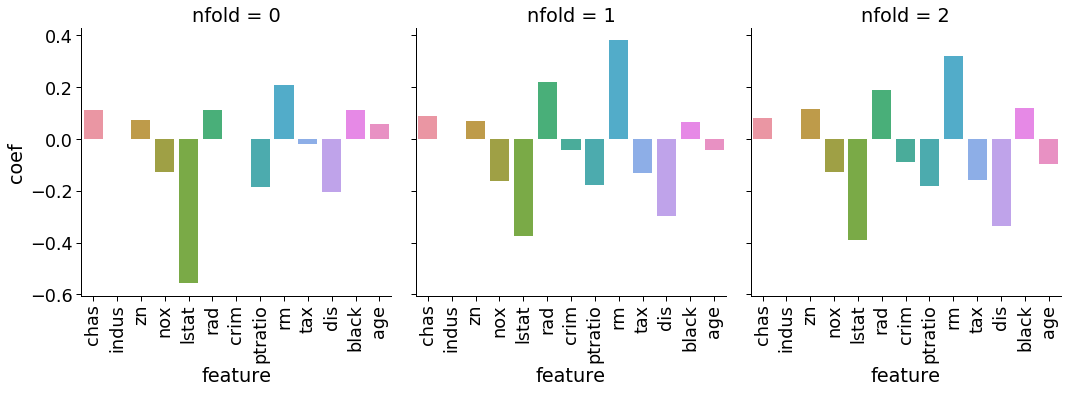

In [45]:
tmp = df_elastic_coef[idx].reset_index(drop=True).unstack().reset_index(name='coef').rename(columns={'level_0': 'feature', 'level_1': 'nfold'})
fg = sns.catplot(data=tmp, kind='bar', x='feature', y='coef', col='nfold')
for ax in fg.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

<h2>Random Forest</h2>

In [46]:
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

df_rforest = pd.DataFrame(columns={'nfold','nestimator','maxdepth','importance','train_score','test_score','r2','mae'})
feature_names = None

for nestimator in [2,5,10,100,1000]:
    for maxdepth in [2,3,5,7,10]:
        for nfold in np.arange(NUMFOLDS):

            # using the same splitted_data as S3D
            path = 'splitted_data/<name>/<nfold>/<type>.csv'

            X_train = pd.read_csv(path.replace('<nfold>',str(nfold)).replace('<name>',data_name).replace('<type>','train'))
            X_test = pd.read_csv(path.replace('<nfold>',str(nfold)).replace('<name>',data_name).replace('<type>','test'))

            if feature_names is None:
                feature_names = X_train.columns.drop('target')

            y_train = X_train.target.values
            y_test = X_test.target.values

            X_train = X_train.drop('target',axis=1).values
            X_test = X_test.drop('target',axis=1).values

            clf = RandomForestRegressor(n_estimators=nestimator, max_depth=maxdepth, random_state=0)
            reg = clf.fit(X_train, y_train)

            importance = clf.feature_importances_

            train_score = clf.score(X_train, y_train)
            test_score = clf.score(X_test, y_test)

            y_pred_rf = reg.predict(X_test)
            r2_score_rf = r2_score(y_test, y_pred_rf)
            
            mae = mean_absolute_error(y_test, y_pred_rf)
            
            df_rforest = df_rforest.append({'nfold':nfold,
                                        'nestimator':nestimator,
                                        'maxdepth':maxdepth,
                                        'importance':importance,
                                        'train_score':train_score,
                                        'test_score':test_score,
                                        'r2':r2_score_rf,
                                        'mae':mae  }, ignore_index=True)

df_rforest = df_rforest.sort_values('nfold')        

# all outcomes        
df_rforest_coef = df_rforest.importance.apply(pd.Series).rename(columns={i:c for i,c in enumerate(feature_names)})

# best hyperparameter (alpha)
idx = df_rforest.groupby(['nfold'])['r2'].transform(max) == df_rforest['r2'] 

/ssd/lespin/virtualenv/python3.5/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [47]:
df_rforest[idx].sort_values('nfold')

,nfold,nestimator,test_score,train_score,r2,mae,maxdepth,importance
72,0,1000,0.881369,0.980151,0.881369,0.262338,10,"[0.0011828274243957033, 0.00609185943492004, 0..."
70,1,1000,0.806866,0.971342,0.806866,0.250567,7,"[0.0005326355331021758, 0.003227318802089107, ..."
74,2,1000,0.731240,0.976406,0.731240,0.301695,10,"[0.0013894922258500379, 0.008432445533025973, ..."


In [48]:
df_rforest_coef[idx]

,chas,indus,zn,nox,lstat,rad,crim,ptratio,rm,tax,dis,black,age
72,0.001183,0.006092,0.001201,0.027294,0.462821,0.007085,0.037882,0.011644,0.331405,0.005000,0.074197,0.013480,0.020717
70,0.000533,0.003227,0.000663,0.007109,0.252012,0.006770,0.046259,0.006863,0.555713,0.011168,0.078234,0.008164,0.023285
74,0.001389,0.008432,0.002367,0.016780,0.391649,0.003046,0.033372,0.008707,0.468582,0.021580,0.015829,0.011652,0.016615


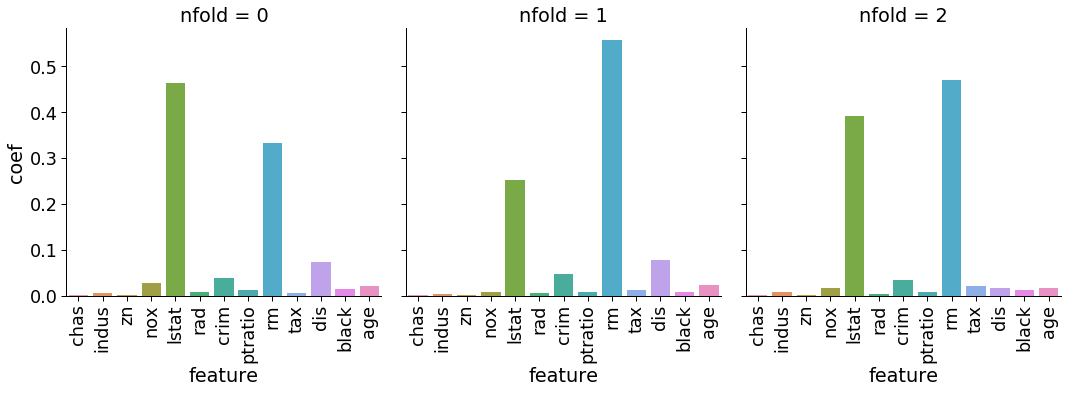

In [49]:
tmp = df_rforest_coef[idx].reset_index(drop=True).unstack().reset_index(name='coef').rename(columns={'level_0': 'feature', 'level_1': 'nfold'})
fg = sns.catplot(data=tmp, kind='bar', x='feature', y='coef', col='nfold')
for ax in fg.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

<h2>Linear SVM</h2>

In [50]:
from sklearn.metrics import r2_score
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_absolute_error

df_lsvm = pd.DataFrame(columns={'nfold','epsilon','tol','maxiter','coef','intercept','train_score','test_score','r2','mae'})
feature_names = None

for epsilon in [0., 0.1, 0.2, 0.3, 0.5]:
    for tol in [1e-2, 1e-5, 1e-10]:
        for maxiter in [10,100,1000,5000]:
            for nfold in np.arange(NUMFOLDS):

                # using the same splitted_data as S3D
                path = 'splitted_data/<name>/<nfold>/<type>.csv'

                X_train = pd.read_csv(path.replace('<nfold>',str(nfold)).replace('<name>',data_name).replace('<type>','train'))
                X_test = pd.read_csv(path.replace('<nfold>',str(nfold)).replace('<name>',data_name).replace('<type>','test'))

                if feature_names is None:
                    feature_names = X_train.columns.drop('target')

                y_train = X_train.target.values
                y_test = X_test.target.values

                X_train = X_train.drop('target',axis=1).values
                X_test = X_test.drop('target',axis=1).values

                clf = LinearSVR(random_state=0, tol=tol, epsilon=epsilon, max_iter=maxiter)
                reg = clf.fit(X_train, y_train)

                coef = clf.coef_
                intercept = clf.intercept_

                train_score = clf.score(X_train, y_train)
                test_score = clf.score(X_test, y_test)

                y_pred_elastic = reg.predict(X_test)
                r2_score_elastic = r2_score(y_test, y_pred_elastic)

                mae = mean_absolute_error(y_test, y_pred_rf)

                df_lsvm = df_lsvm.append({'nfold':nfold,
                                            'epsilon':epsilon,
                                            'tol':tol,
                                            'maxiter':maxiter,
                                            'coef':coef,
                                            'intercept':intercept,
                                            'train_score':train_score,
                                            'test_score':test_score,
                                            'r2':r2_score_elastic,
                                            'mae':mae
                                               }, ignore_index=True)

df_lsvm = df_lsvm.sort_values('nfold')        

# all outcomes        
df_lsvm_coef = df_lsvm.coef.apply(pd.Series).rename(columns={i:c for i,c in enumerate(feature_names)})

# best hyperparameter (alpha)
idx = df_lsvm.groupby(['nfold'])['r2'].transform(max) == df_lsvm['r2'] 

In [51]:
tmp = df_lsvm[idx].sort_values('nfold').drop_duplicates(['nfold'])
idx = [i in tmp.index for i in df_lsvm.index]
tmp

,nfold,test_score,intercept,train_score,maxiter,tol,r2,mae,coef,epsilon
63,0,0.784953,[-0.11378565011340437],0.658364,100,1.000000e-10,0.784953,0.705665,"[0.04291346421970898, 0.03109860862185071, 0.0...",0.1
103,1,0.605201,[-0.07613588879243892],0.713472,1000,1.000000e-10,0.605201,0.778285,"[0.05488645095879508, 0.001585844917123021, 0....",0.2
170,2,0.649308,[0.04246753653588137],0.734883,10,1.000000e-10,0.649308,0.301695,"[0.08102527303425959, 0.0931301750738566, 0.09...",0.5


In [52]:
df_lsvm_coef[idx]

,chas,indus,zn,nox,lstat,rad,crim,ptratio,rm,tax,dis,black,age
63,0.042913,0.031099,0.074911,-0.146527,-0.337484,0.236968,-0.001941,-0.163914,0.369513,-0.242386,-0.215474,0.137963,-0.047583
103,0.054886,0.001586,0.029446,-0.103627,-0.215675,0.173790,-0.082161,-0.172330,0.478816,-0.160054,-0.238512,0.059355,-0.135206
170,0.081025,0.093130,0.094700,-0.080367,-0.523718,0.352331,-0.054421,-0.193003,0.355959,-0.346923,-0.467061,0.031608,-0.217181


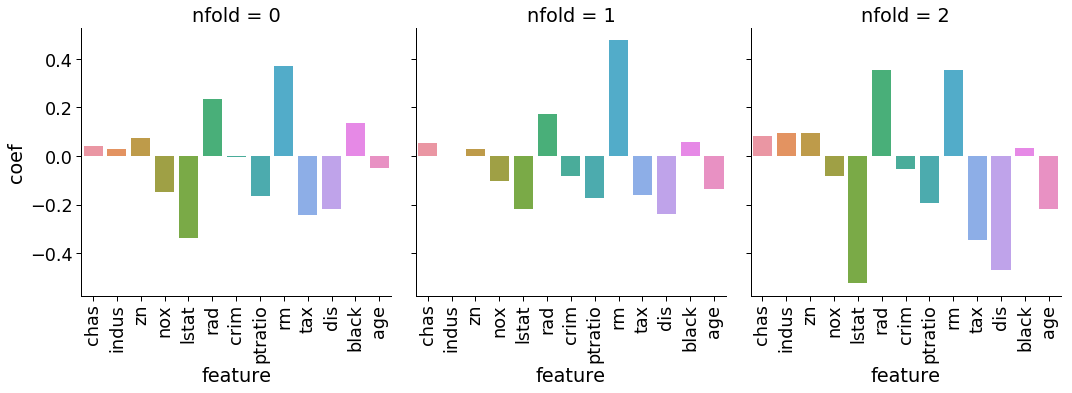

In [53]:
tmp = df_lsvm_coef[idx].reset_index(drop=True).unstack().reset_index(name='coef').rename(columns={'level_0': 'feature', 'level_1': 'nfold'})
fg = sns.catplot(data=tmp, kind='bar', x='feature', y='coef', col='nfold')
for ax in fg.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

<h3>Comparison Summary:</h3>
<p><a href="https://docs.google.com/spreadsheets/d/14BLZ1WpwvxyJnRvd19uieoVwY8Yji4Q7oGS2PPWG_rk/edit?usp=sharing">docs.google.com/spreadsheets/d/14BLZ1WpwvxyJnRvd19uieoVwY8Yji4Q7oGS2PPWG_rk</a></p>